# Boat Object Detection with YOLO

In this exercise, you will fine-tune a YOLO model for boat detection in satellite imagery.

In [9]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import pandas as pd

## Data Collection

Download the training and test datasets.

In [10]:
# URLs for the dataset files
data_train_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_train.pkl'
data_train_labels_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/y_train.pkl'
data_test_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_test.pkl'

def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name}')

# Download the files
download_file(data_train_features_url, 'X_train.pkl')
download_file(data_train_labels_url, 'y_train.pkl')
download_file(data_test_features_url, 'X_test.pkl')

Downloaded X_train.pkl
Downloaded y_train.pkl
Downloaded X_test.pkl


In [11]:
# Load the training data
with open('X_train.pkl', 'rb') as f:
    X = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y = pickle.load(f)

print(f"Loaded {len(X)} training images")
print(f"Sample image shape: {X[0].shape}")
print(f"Sample labels shape: {y[0].shape}")
print(f"Sample labels (YOLO format - class_id, x_center, y_center, width, height):\n{y[0]}")

Loaded 496 training images
Sample image shape: (418, 466, 3)
Sample labels shape: (1, 5)
Sample labels (YOLO format - class_id, x_center, y_center, width, height):
[[0.       0.659871 0.57177  0.109442 0.162679]]


## Data Visualization

Display sample images with bounding boxes.

In [12]:
def plot_image_with_boxes(image, boxes, ax=None):
    """
    Plot an image with bounding boxes
    boxes: numpy array with shape (n, 5) - [class_id, x_center, y_center, width, height]
    All box coordinates are normalized (0-1)
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.imshow(image)
    height, width = image.shape[:2]

    # Draw each bounding box
    for box in boxes:
        class_id, x_center, y_center, box_width, box_height = box

        # Convert from normalized YOLO format to pixel coordinates
        x_center_px = x_center * width
        y_center_px = y_center * height
        box_width_px = box_width * width
        box_height_px = box_height * height

        # Calculate top-left corner
        x1 = x_center_px - box_width_px / 2
        y1 = y_center_px - box_height_px / 2

        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), box_width_px, box_height_px,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        # Add label
        ax.text(x1, y1-5, 'boat', color='red', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    ax.axis('off')
    return ax

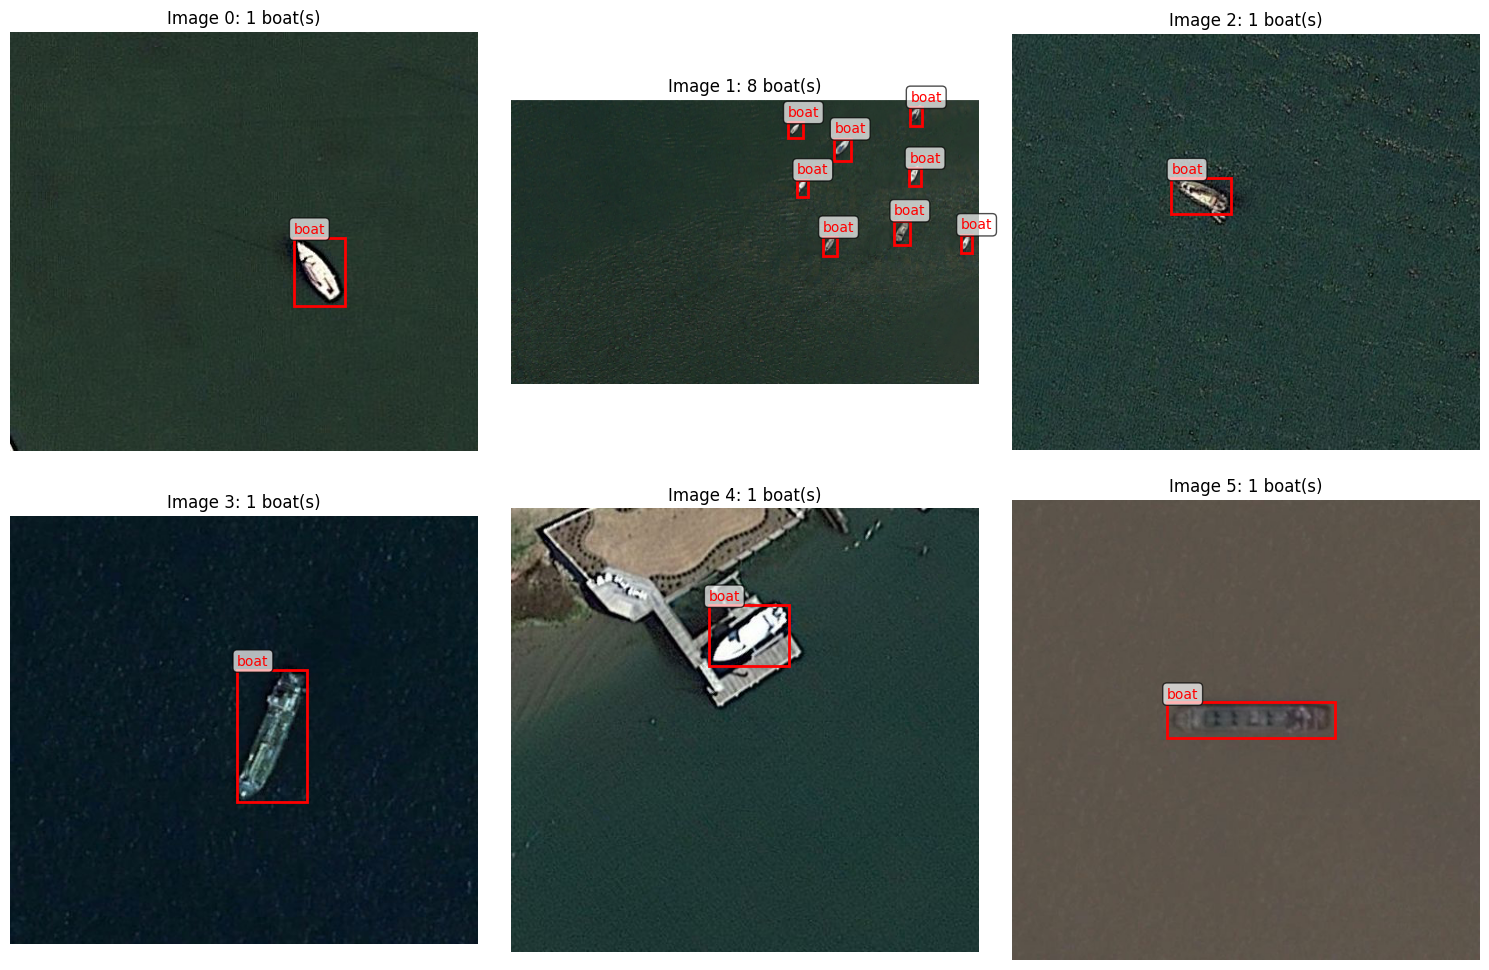

In [13]:
# Display 5 sample images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    plot_image_with_boxes(X[i], y[i], ax=axes[i])
    axes[i].set_title(f'Image {i}: {len(y[i])} boat(s)')

plt.tight_layout()
plt.show()

## Model Setup

Load a pre-trained YOLO model and test it on the training images.

In [14]:
#pip install ultralytics

In [15]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (nano version)
model = YOLO('yolov8n.pt')

print("Model loaded successfully!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Model loaded successfully!


In [16]:
# Test the pre-trained model on a sample image
# Save a sample image temporarily
from PIL import Image
sample_img = Image.fromarray(X[0])
sample_img.save('temp_sample.png')

# Run prediction
results = model.predict(source='temp_sample.png', conf=0.25)

print(f"Pre-trained model detected {len(results[0].boxes)} objects")
print("Note: The pre-trained model may not detect boats well - you need to fine-tune it!")


image 1/1 /content/temp_sample.png: 576x640 1 tennis racket, 316.6ms
Speed: 15.9ms preprocess, 316.6ms inference, 34.0ms postprocess per image at shape (1, 3, 576, 640)
Pre-trained model detected 1 objects
Note: The pre-trained model may not detect boats well - you need to fine-tune it!


## Fine-tune your YOLO model

Your task is to fine-tune the YOLO model on the boat detection dataset to achieve a mAP50 score of at least 0.73 on the test set.

In [17]:
# Your code here
# Fine-tune the YOLO model
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(X_val))
print(len(y_train), len(y_val))

396 100
396 100


In [18]:
import os
from PIL import Image
# 1 Enrengistrement au format Yolo
# Créer les dossiers
for split in ['train', 'val']:
    os.makedirs(f"boat_dataset/{split}/images", exist_ok=True)
    os.makedirs(f"boat_dataset/{split}/labels", exist_ok=True)

#2 Sauvegarder les images et les labels au format YOLO
def save_yolo_data(X_data, y_data, split):
    for i, (img_array, label_array) in enumerate(zip(X_data, y_data)):
        # Sauvegarder l'image
        img = Image.fromarray(img_array)

        # Convertir en RGB si nécessaire (pour éviter l'erreur RGBA)
        if img.mode == 'RGBA':
            img = img.convert('RGB')

        img_path = f"boat_dataset/{split}/images/img_{i}.jpg"
        img.save(img_path)

        # Sauvegarder le label
        label_path = f"boat_dataset/{split}/labels/img_{i}.txt"
        with open(label_path, 'w') as f:
            for label in label_array:
                class_id, x_center, y_center, width, height = label
                f.write(f"{int(class_id)} {x_center} {y_center} {width} {height}\n")


save_yolo_data(X_train, y_train, 'train')
save_yolo_data(X_val, y_val, 'val')


In [19]:
# création boat_dataset.yaml
with open("boat_dataset.yaml", "w") as f:
    f.write(
        "train: boat_dataset/train/images\n"
        "val: boat_dataset/val/images\n"
        "nc: 1\n"
        "names: ['boat']\n"
    )

In [20]:
# Lancer le fine-tuning
model.train(data="boat_dataset.yaml",
            epochs=10,
            imgsz=640,
            batch=16,
            name="nare_best")

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=boat_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=nare_best, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eac22f051f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [22]:
results = model.val()

# Afficher le mAP50
print(f"mAP@0.5 = {results.box.map50:.3f}")
print(results)

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (AMD EPYC 7B12)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1007.6±507.0 MB/s, size: 19.0 KB)
val: Scanning /content/boat_dataset/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 62.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 0.4it/s 17.0s
                   all        100        160      0.903      0.697      0.787      0.564
Speed: 1.5ms preprocess, 157.6ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to /content/runs/detect/val2
mAP@0.5 = 0.787
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eac22f082f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array(

In [21]:
metrics = model.val(data="boat_dataset.yaml")

# Affiche le mAP@0.5
print(f"mAP50 = {metrics.box.map50:.3f}")

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (AMD EPYC 7B12)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 518.6±260.5 MB/s, size: 18.4 KB)
val: Scanning /content/boat_dataset/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 51.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 0.4it/s 17.0s
                   all        100        160      0.903      0.697      0.787      0.564
Speed: 1.5ms preprocess, 157.1ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to /content/runs/detect/val
mAP50 = 0.787


## Generate Predictions for Test Set

Generate predictions on the test set and save them in the required CSV format.

In [23]:
# Load test data
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

print(f"Loaded {len(X_test)} test images")


Loaded 125 test images


In [24]:
# Generate predictions on test set
# Your trained model should be used here
# Format: CSV with columns: image_id, box_idx, class_id, confidence, x_center, y_center, width, height

model = YOLO('runs/detect/nare_best/weights/best.pt')
predictions = []

for img_idx, img in enumerate(X_test):
    # Save image temporarily
    temp_img = Image.fromarray(img)
    temp_img.save('temp_test.png')

    # Run prediction with your fine-tuned model
    # Replace 'model' with your fine-tuned model
    results = model.predict(source='temp_test.png', conf=0.25, verbose=False)

    # Extract predictions
    for box_idx, box in enumerate(results[0].boxes):
        # Get box data in YOLO format (normalized coordinates)
        x_center, y_center, width, height = box.xywhn[0].cpu().numpy()
        confidence = box.conf[0].cpu().numpy()
        class_id = int(box.cls[0].cpu().numpy())

        predictions.append({
            'image_id': img_idx,
            'box_idx': box_idx,
            'class_id': 0,  # Always 0 for boat
            'confidence': float(confidence),
            'x_center': float(x_center),
            'y_center': float(y_center),
            'width': float(width),
            'height': float(height)
        })

    if (img_idx + 1) % 10 == 0:
        print(f"Processed {img_idx + 1}/{len(X_test)} images")

print(f"\nTotal predictions: {len(predictions)}")

Processed 10/125 images
Processed 20/125 images
Processed 30/125 images
Processed 40/125 images
Processed 50/125 images
Processed 60/125 images
Processed 70/125 images
Processed 80/125 images
Processed 90/125 images
Processed 100/125 images
Processed 110/125 images
Processed 120/125 images

Total predictions: 336


In [25]:
# Save predictions to CSV
df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")
print("\nFirst few predictions:")
print(df_predictions.head(10))

Predictions saved to predictions.csv

First few predictions:
   image_id  box_idx  class_id  confidence  x_center  y_center     width  \
0         0        0         0    0.957588  0.566833  0.435774  0.163292   
1         1        0         0    0.341882  0.719629  0.391968  0.038952   
2         1        1         0    0.336417  0.709154  0.395362  0.060473   
3         2        0         0    0.942805  0.475864  0.419139  0.308352   
4         2        1         0    0.332651  0.725264  0.032819  0.201059   
5         2        2         0    0.319703  0.507055  0.439869  0.242514   
6         2        3         0    0.301078  0.411157  0.260040  0.210404   
7         3        0         0    0.927936  0.364727  0.361158  0.231360   
8         4        0         0    0.944797  0.466334  0.415484  0.117742   
9         5        0         0    0.987578  0.431440  0.459943  0.364416   

     height  
0  0.127766  
1  0.030616  
2  0.042100  
3  0.221042  
4  0.065638  
5  0.188832  
6  0